In [1]:
import matplotlib.pyplot as plt 
import scipy.misc
import numpy as np
from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, Cropping2D
from keras.layers import MaxPooling2D, ZeroPadding2D, BatchNormalization, Activation
from keras.models import Model
from keras.utils.layer_utils import print_summary
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

from keras import __version__ as kv
from scipy import __version__ as sv
from matplotlib import __version__ as mv
from numpy import __version__ as nv

print kv
print sv
print mv
print nv

Using TensorFlow backend.


2.0.5
0.19.1
2.0.0
1.13.0


In [2]:
# Local files
import utils
reload(utils)

<module 'utils' from 'utils.pyc'>

# Data

### Config

In [3]:
trained_model_dir = '/home/ubuntu/data/sar/experiment_crops_20170815/trained_models/1.0-mph_as_kd-baseline-simple_CNN_from_scratch/'

In [5]:
train_dir = '/home/ubuntu/data/sar/experiment_crops_20170815/train/50x50/'
valid_dir = '/home/ubuntu/data/sar/experiment_crops_20170815/validate/50x50/'

In [6]:
input_shape = (50, 50, 1)
num_classes = 3

### Convert tif2png

In [7]:
utils.tif2png(src_dir=train_dir+"oil_and_gas_infrastructure/", dest_dir=train_dir+"oil_and_gas_infrastructure/")
utils.tif2png(src_dir=train_dir+"other/", dest_dir=train_dir+"other/")
utils.tif2png(src_dir=train_dir+"turbine/", dest_dir=train_dir+"turbine/")

/home/ubuntu/data/sar/experiment_crops_20170815/train/50x50/oil_and_gas_infrastructure/ 500
/home/ubuntu/data/sar/experiment_crops_20170815/train/50x50/oil_and_gas_infrastructure/ 500 1000
/home/ubuntu/data/sar/experiment_crops_20170815/train/50x50/other/ 500
/home/ubuntu/data/sar/experiment_crops_20170815/train/50x50/other/ 500 1000
/home/ubuntu/data/sar/experiment_crops_20170815/train/50x50/turbine/ 1000
/home/ubuntu/data/sar/experiment_crops_20170815/train/50x50/turbine/ 1000 2000


In [8]:
utils.tif2png(src_dir=valid_dir+"oil_and_gas_infrastructure/", dest_dir=valid_dir+"oil_and_gas_infrastructure/")
utils.tif2png(src_dir=valid_dir+"other/", dest_dir=valid_dir+"other/")
utils.tif2png(src_dir=valid_dir+"turbine/", dest_dir=valid_dir+"turbine/")

/home/ubuntu/data/sar/experiment_crops_20170815/validate/50x50/oil_and_gas_infrastructure/ 125
/home/ubuntu/data/sar/experiment_crops_20170815/validate/50x50/oil_and_gas_infrastructure/ 125 250
/home/ubuntu/data/sar/experiment_crops_20170815/validate/50x50/other/ 125
/home/ubuntu/data/sar/experiment_crops_20170815/validate/50x50/other/ 125 250
/home/ubuntu/data/sar/experiment_crops_20170815/validate/50x50/turbine/ 250
/home/ubuntu/data/sar/experiment_crops_20170815/validate/50x50/turbine/ 250 500


Let's visualise/check the conversion worked correctly:

/home/ubuntu/data/sar/experiment_crops_20170815/train/50x50/oil_and_gas_infrastructure/S1B_IW_GRDH_1SDV_20170709T061319_20170709T061344_006407_00B43B_EFB1_terrain_correction_69.png


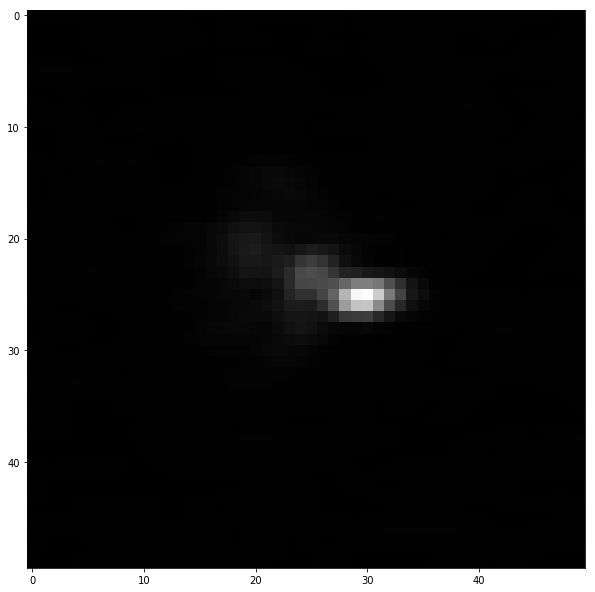

In [11]:
utils.display_image("/home/ubuntu/data/sar/experiment_crops_20170815/train/50x50/oil_and_gas_infrastructure/" \
                    "S1B_IW_GRDH_1SDV_20170709T061319_20170709T061344_006407_00B43B_EFB1_terrain_correction_69.png")

Looks quite different to the tif file in QGIS - although this could be because QGIS rescales intensities. Let's check the array:

In [17]:
import cv2
import rasterio

In [22]:
with rasterio.open("/home/ubuntu/data/sar/experiment_crops_20170815/train/50x50/oil_and_gas_infrastructure/" \
                    "S1B_IW_GRDH_1SDV_20170709T061319_20170709T061344_006407_00B43B_EFB1_terrain_correction_69.png", mode="r") as raster:
    rasterio_array = raster.read(1)

=== 20170821 Note: Ooops - read in png with rasterio and cv2. Let check what we actually wanted to check === 

In [8]:
import rasterio
import numpy as np

In [9]:
with rasterio.open("/home/ubuntu/data/sar/experiment_crops_20170815/train/50x50/oil_and_gas_infrastructure/" \
                    "S1B_IW_GRDH_1SDV_20170709T061319_20170709T061344_006407_00B43B_EFB1_terrain_correction_69.tif", mode="r") as raster:
    rasterio_array = raster.read(1)

In [10]:
np.set_printoptions(threshold=np.nan)

print(rasterio_array[25,:])

[ 0.00248293  0.00304658  0.00343856  0.0037784   0.00420436  0.00447489
  0.00478828  0.00505411  0.00490007  0.00551279  0.00597329  0.0067725
  0.00824543  0.01055317  0.01191709  0.01363397  0.01785034  0.023055
  0.02635294  0.02478135  0.01701678  0.02809606  0.05204867  0.11299562
  0.15419009  0.15461712  0.2194076   0.31673673  0.57419163  0.78672653
  0.81263798  0.65055662  0.38451555  0.21549205  0.07361336  0.03781835
  0.01233841  0.00426493  0.00295459  0.00405911  0.00286321  0.00247345
  0.00322912  0.00280766  0.0019609   0.00244714  0.00311382  0.0036213
  0.00332013  0.00247109]


!!!!!!Damn - they're different!!!

=== END Note ===

In [26]:
cv2_array = cv2.imread("/home/ubuntu/data/sar/experiment_crops_20170815/train/50x50/oil_and_gas_infrastructure/" \
                    "S1B_IW_GRDH_1SDV_20170709T061319_20170709T061344_006407_00B43B_EFB1_terrain_correction_69.png")

In [27]:
np.set_printoptions(threshold=np.nan)

print(rasterio_array[25,:])

[  1   1   1   1   1   1   1   1   1   2   2   2   2   3   4   4   5   7
   8   8   5   9  16  35  48  48  69  99 180 247 255 204 121  67  23  12
   4   1   1   1   1   1   1   1   0   1   1   1   1   1]


In [28]:
print(cv2_array[25,:,1])

[  1   1   1   1   1   1   1   1   1   2   2   2   2   3   4   4   5   7
   8   8   5   9  16  35  48  48  69  99 180 247 255 204 121  67  23  12
   4   1   1   1   1   1   1   1   0   1   1   1   1   1]


Same=Great! Let's just check a few more for arguments sake.

/home/ubuntu/data/sar/experiment_crops_20170815/train/50x50/oil_and_gas_infrastructure/S1A_IW_GRDH_1SDV_20170216T060554_20170216T060619_015305_01916C_72E0_terrain_correction_133.png


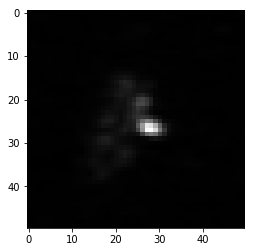

In [30]:
utils.display_rnd_image(train_dir+"oil_and_gas_infrastructure/")

/home/ubuntu/data/sar/experiment_crops_20170815/train/50x50/other/S1A_IW_GRDH_1SDV_20170514T174100_20170514T174125_016581_01B805_47DB_subset4_20.png


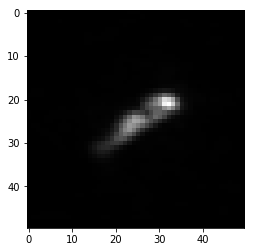

In [31]:
utils.display_rnd_image(train_dir+"other/")

/home/ubuntu/data/sar/experiment_crops_20170815/train/50x50/turbine/S1B_IW_GRDH_1SDV_20170527T062125_20170527T062150_005780_00A21A_8AC7_terrain_correction_248.png


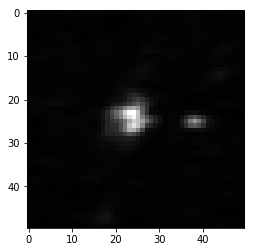

In [32]:
utils.display_rnd_image(train_dir+"turbine/")

### Create Generators

In [33]:
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(50, 50),
        batch_size=20,
        class_mode='categorical', 
        color_mode='grayscale')

validation_generator = test_datagen.flow_from_directory(
        valid_dir, 
        target_size=(50, 50),
        shuffle=False,
        batch_size=10,
        class_mode='categorical',
        color_mode='grayscale')

Found 2000 images belonging to 3 classes.
Found 500 images belonging to 3 classes.


# Experiments

## simple/baseline model (3 layers, no regularisation)

In [34]:
classifier_input = Input(shape=input_shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(classifier_input)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Flatten()(x)
x = Dense(num_classes, activation='softmax')(x)

model = Model(outputs=x, inputs=classifier_input)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 50, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
__________

In [36]:
lr = 0.001
K.set_value(model.optimizer.lr, lr)

In [37]:
model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=60)

Epoch 1/10
100/100 [==============================] - 10s - loss: 0.5579 - acc: 0.7630 - val_loss: 0.4020 - val_acc: 0.8400
Epoch 2/10
100/100 [==============================] - 10s - loss: 0.3445 - acc: 0.8655 - val_loss: 0.3123 - val_acc: 0.8883
Epoch 3/10
100/100 [==============================] - 10s - loss: 0.2554 - acc: 0.8950 - val_loss: 0.2966 - val_acc: 0.8950
Epoch 4/10
100/100 [==============================] - 10s - loss: 0.2135 - acc: 0.9180 - val_loss: 0.2823 - val_acc: 0.9150
Epoch 5/10
100/100 [==============================] - 10s - loss: 0.1818 - acc: 0.9360 - val_loss: 0.2586 - val_acc: 0.9233
Epoch 6/10
100/100 [==============================] - 10s - loss: 0.1591 - acc: 0.9440 - val_loss: 0.3043 - val_acc: 0.9267
Epoch 7/10
100/100 [==============================] - 10s - loss: 0.1559 - acc: 0.9465 - val_loss: 0.2558 - val_acc: 0.9183
Epoch 8/10
100/100 [==============================] - 10s - loss: 0.1267 - acc: 0.9540 - val_loss: 0.2265 - val_acc: 0.9383
Epoch 9/

In [38]:
lr = 0.001
K.set_value(model.optimizer.lr, lr)
model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=2,
        validation_data=validation_generator,
        validation_steps=60)

Epoch 1/2
100/100 [==============================] - 10s - loss: 0.0797 - acc: 0.9710 - val_loss: 0.2899 - val_acc: 0.9433
Epoch 2/2
100/100 [==============================] - 10s - loss: 0.0800 - acc: 0.9720 - val_loss: 0.2876 - val_acc: 0.9317


In [39]:
lr = 0.001
K.set_value(model.optimizer.lr, lr)
model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=2,
        validation_data=validation_generator,
        validation_steps=60)

Epoch 1/2
100/100 [==============================] - 10s - loss: 0.0703 - acc: 0.9770 - val_loss: 0.2866 - val_acc: 0.9317
Epoch 2/2
100/100 [==============================] - 10s - loss: 0.0620 - acc: 0.9785 - val_loss: 0.3485 - val_acc: 0.9283


In [40]:
lr = 0.0001
K.set_value(model.optimizer.lr, lr)
model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=2,
        validation_data=validation_generator,
        validation_steps=60)

Epoch 1/2
100/100 [==============================] - 10s - loss: 0.0312 - acc: 0.9905 - val_loss: 0.3205 - val_acc: 0.9350
Epoch 2/2
100/100 [==============================] - 10s - loss: 0.0244 - acc: 0.9950 - val_loss: 0.3042 - val_acc: 0.9383


In [41]:
lr = 0.0001
K.set_value(model.optimizer.lr, lr)
model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=2,
        validation_data=validation_generator,
        validation_steps=60)

Epoch 1/2
100/100 [==============================] - 10s - loss: 0.0209 - acc: 0.9950 - val_loss: 0.3236 - val_acc: 0.9383
Epoch 2/2
100/100 [==============================] - 10s - loss: 0.0198 - acc: 0.9960 - val_loss: 0.3063 - val_acc: 0.9417


In [42]:
model.save_weights(trained_model_dir + "simple_model_valAcc94.h5")

### Lets visualise and evaluate/plot predictions

In [43]:
validation_generator.reset()

In [44]:
preds = model.predict_generator(validation_generator,50)
preds.shape

(500, 3)

In [45]:
from sklearn.metrics import confusion_matrix

In [46]:
sorted(list(validation_generator.class_indices))

['oil_and_gas_infrastructure', 'other', 'turbine']

In [47]:
y_pred = np.argmax(preds, axis=1)

In [48]:
y_true = validation_generator.classes
labels = [0,1,2] # sorted(list(validation_generator.class_indices))
y_pred = np.argmax(preds, axis=1)
cm = confusion_matrix(y_true, y_pred, labels)
print(cm)

[[117   5   3]
 [ 12 107   6]
 [  2   5 243]]


Confusion matrix, without normalization
[[117   5   3]
 [ 12 107   6]
 [  2   5 243]]


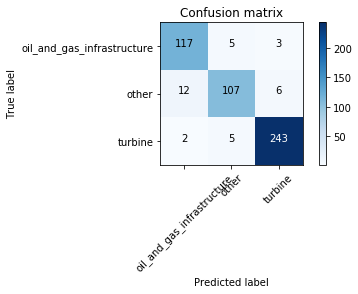

In [49]:
utils.plot_confusion_matrix(cm, sorted(list(validation_generator.class_indices)))

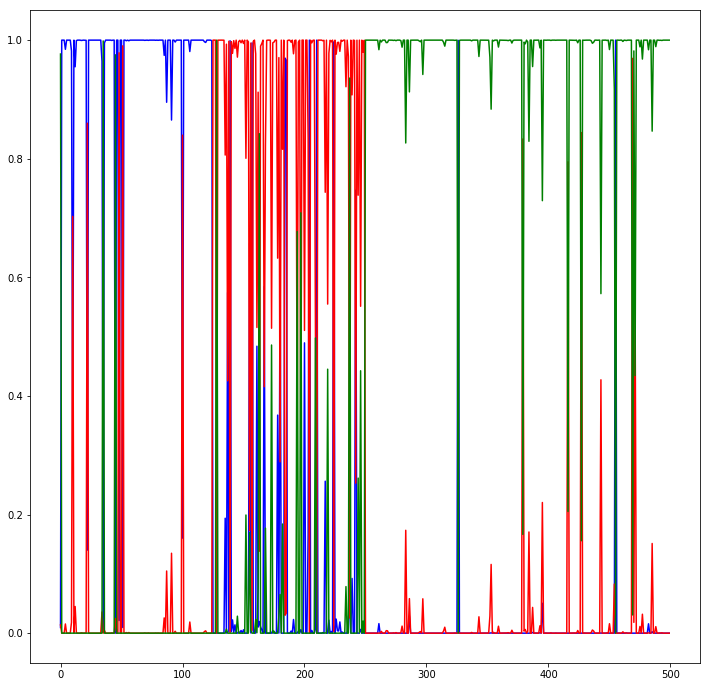

In [50]:
plt.figure(figsize=(12,12))
plt.plot(preds[:,0], 'b')
plt.plot(preds[:,1], 'r')
plt.plot(preds[:,2], 'g')
plt.show()

In [51]:
preds[498]

array([  2.26995818e-11,   1.17433818e-09,   1.00000000e+00], dtype=float32)

## changing model to deal with overfitting - batchnorm? 


In [52]:
classifier_input = Input(shape=input_shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(classifier_input)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Flatten()(x)
x = Dense(num_classes, activation='softmax')(x)

model_batchnorm = Model(outputs=x, inputs=classifier_input)
model_batchnorm.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [53]:
model_batchnorm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50, 50, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 64)        36928     
__________

In [54]:
lr = 0.0001
K.set_value(model.optimizer.lr, lr)
model_batchnorm.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=2,
        validation_data=validation_generator,
        validation_steps=60)

Epoch 1/2
100/100 [==============================] - 15s - loss: 0.4243 - acc: 0.8305 - val_loss: 0.9583 - val_acc: 0.8917
Epoch 2/2
100/100 [==============================] - 15s - loss: 0.2165 - acc: 0.9270 - val_loss: 0.7879 - val_acc: 0.9017


## move position of batchnorm? need to split the activation from the conv layer first

In [55]:
classifier_input = Input(shape=input_shape)

x = Conv2D(32, (3, 3), activation=None, padding='same')(classifier_input)
x = Activation('relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation=None, padding='same')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation=None, padding='same')(x)
x = Activation('relu')(x)
x = Flatten()(x)
x = Dense(num_classes, activation='softmax')(x)

model_split_activation = Model(outputs=x, inputs=classifier_input)
model_split_activation.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [56]:
lr = 0.001
K.set_value(model.optimizer.lr, lr)
model_split_activation.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=2,
        validation_data=validation_generator,
        validation_steps=60)

Epoch 1/2
100/100 [==============================] - 10s - loss: 0.5546 - acc: 0.7520 - val_loss: 0.3910 - val_acc: 0.8783
Epoch 2/2
100/100 [==============================] - 10s - loss: 0.3628 - acc: 0.8580 - val_loss: 0.4171 - val_acc: 0.8267


In [57]:
# add the batchnorm before the activation. (need dense layers mid way? )

x = Conv2D(32, (3, 3), activation=None, padding='same')(classifier_input)
x = BatchNormalization(axis=-1)(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation=None, padding='same')(x)
x = BatchNormalization(axis=-1)(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation=None, padding='same')(x)
x = BatchNormalization(axis=-1)(x)
x = Activation('relu')(x)
x = Flatten()(x)
x = Dense(num_classes, activation='softmax')(x)

model_split_activation_batchnorm = Model(outputs=x, inputs=classifier_input)
model_split_activation_batchnorm.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [58]:
model_split_activation_batchnorm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 50, 50, 1)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 50, 50, 32)        320       
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
activation_4 (Activation)    (None, 50, 50, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 25, 25, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 25, 25, 64)        256       
__________

## validation accuracy is jumping around so we will try increasing the batch size

In [59]:
train_datagen2 = ImageDataGenerator(rescale=1./255)

test_datagen2 = ImageDataGenerator(rescale=1./255)

train_generator2 = train_datagen2.flow_from_directory(
        train_dir,
        target_size=(50, 50),
        batch_size=40,
        class_mode='categorical', 
        color_mode='grayscale')

validation_generator2 = test_datagen2.flow_from_directory(
        valid_dir, 
        target_size=(50, 50),
        shuffle=False,
        batch_size=20,
        class_mode='categorical',
        color_mode='grayscale')

Found 2000 images belonging to 3 classes.
Found 500 images belonging to 3 classes.


In [60]:
lr = 0.0001
K.set_value(model.optimizer.lr, lr)
model_split_activation_batchnorm.fit_generator(
        train_generator2,
        steps_per_epoch=100,
        epochs=2,
        validation_data=validation_generator2,
        validation_steps=60)

Epoch 1/2
100/100 [==============================] - 48s - loss: 0.6198 - acc: 0.8012 - val_loss: 1.3899 - val_acc: 0.3125
Epoch 2/2
100/100 [==============================] - 48s - loss: 0.2568 - acc: 0.9068 - val_loss: 2.3841 - val_acc: 0.2917


## changing model to include dropout 

In [61]:
classifier_input = Input(shape=input_shape)

p=0.6

x = Conv2D(32, (3, 3), activation=None, padding='same')(classifier_input)
x = BatchNormalization(axis=-1)(x)
x = Activation('relu')(x)
x = Dropout(p/4)(x)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation=None, padding='same')(x)
x = BatchNormalization(axis=-1)(x)
x = Activation('relu')(x)
x = Dropout(p/2)(x)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation=None, padding='same')(x)
x = BatchNormalization(axis=-1)(x)
x = Activation('relu')(x)
x = Dropout(p)(x)
x = Flatten()(x)
x = Dense(num_classes, activation='softmax')(x)

model_batchnorm_dropout = Model(outputs=x, inputs=classifier_input)
model_batchnorm_dropout.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [62]:
lr = 0.001
K.set_value(model.optimizer.lr, lr)
model_batchnorm_dropout.fit_generator(
        train_generator2,
        steps_per_epoch=100,
        epochs=1,
        validation_data=validation_generator2,
        validation_steps=60)

Epoch 1/1
100/100 [==============================] - 53s - loss: 0.7397 - acc: 0.7657 - val_loss: 1.2004 - val_acc: 0.2083


In [63]:
lr = 0.0001
K.set_value(model.optimizer.lr, lr)
model_batchnorm_dropout.fit_generator(
        train_generator2,
        steps_per_epoch=100,
        epochs=1,
        validation_data=validation_generator2,
        validation_steps=60)

Epoch 1/1
100/100 [==============================] - 53s - loss: 0.3316 - acc: 0.8847 - val_loss: 2.1080 - val_acc: 0.2083


In [64]:
lr = 0.0001
K.set_value(model.optimizer.lr, lr)
model_batchnorm_dropout.fit_generator(
        train_generator2,
        steps_per_epoch=100,
        epochs=1,
        validation_data=validation_generator2,
        validation_steps=60)

Epoch 1/1
100/100 [==============================] - 53s - loss: 0.2258 - acc: 0.9190 - val_loss: 1.8695 - val_acc: 0.2292


## Finally data augmentation (on pretrained best model = model_batchnorm_dropout)

In [65]:
train_datagen_aug = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=90,
        horizontal_flip=True,
        vertical_flip=True)

test_datagen_aug = ImageDataGenerator(rescale=1./255)

train_generator_aug = train_datagen_aug.flow_from_directory(
        train_dir,
        target_size=(50, 50),
        batch_size=40,
        class_mode='categorical', 
        color_mode='grayscale')

validation_generator_aug = test_datagen_aug.flow_from_directory(
        valid_dir, 
        target_size=(50, 50),
        shuffle=False,
        batch_size=20,
        class_mode='categorical',
        color_mode='grayscale')

Found 2000 images belonging to 3 classes.
Found 500 images belonging to 3 classes.


In [66]:
lr = 0.0001
K.set_value(model.optimizer.lr, lr)
model_batchnorm_dropout.fit_generator(
        train_generator2,
        steps_per_epoch=100,
        epochs=1,
        validation_data=validation_generator2,
        validation_steps=60)

Epoch 1/1
100/100 [==============================] - 53s - loss: 0.1706 - acc: 0.9373 - val_loss: 1.1963 - val_acc: 0.4825


In [67]:
lr = 0.0001
K.set_value(model.optimizer.lr, lr)
model_batchnorm_dropout.fit_generator(
        train_generator2,
        steps_per_epoch=100,
        epochs=1,
        validation_data=validation_generator2,
        validation_steps=60)

Epoch 1/1
100/100 [==============================] - 53s - loss: 0.1341 - acc: 0.9493 - val_loss: 1.1925 - val_acc: 0.5292


In [68]:
lr = 0.0001
K.set_value(model.optimizer.lr, lr)
model_batchnorm_dropout.fit_generator(
        train_generator2,
        steps_per_epoch=100,
        epochs=1,
        validation_data=validation_generator2,
        validation_steps=60)

Epoch 1/1
100/100 [==============================] - 53s - loss: 0.1391 - acc: 0.9533 - val_loss: 1.4510 - val_acc: 0.4883


In [69]:
lr = 0.0001
K.set_value(model.optimizer.lr, lr)
model_batchnorm_dropout.fit_generator(
        train_generator2,
        steps_per_epoch=100,
        epochs=1,
        validation_data=validation_generator2,
        validation_steps=60)

Epoch 1/1
100/100 [==============================] - 53s - loss: 0.1131 - acc: 0.9645 - val_loss: 0.5356 - val_acc: 0.8317


In [70]:
model.save_weights(trained_model_dir + "simple_model_with_dataAug_valAcc96.h5")